In [1]:
import math 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from functools import partial
from typing import Dict, Tuple, List
from sortedcontainers import SortedDict
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col, expr, udf, count, avg, sum, from_unixtime, unix_timestamp, dayofweek, hour, month
from pyspark.sql.types import DoubleType
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [2]:
spark = (
    SparkSession.builder
    .appName("FraudDetection")
    .master("local[*]")
    # the number of executors this job needs
    .config("spark.executor.instances", 2)
    # the number of CPU cores memory this needs from the executor,
    # it would be reserved on the worker
    .config("spark.executor.cores", "3")
    .config("spark.executor.memory", "12G")
    .config("spark.hadoop.fs.file.impl", "org.apache.hadoop.fs.RawLocalFileSystem")
    .getOrCreate()
)
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/29 11:26:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# sc.stop()

In [4]:
dataset_path = r"PS_20174392719_1491204439457_log.csv"
df = spark.read.option("header", "true").csv(dataset_path)

In [ ]:
# display csv file top 10 rows
df.show(10)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [ ]:
# display csv file schema
df.printSchema()

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)



In [ ]:
# info about the dataset using .info() method
df.describe().show()

23/11/29 00:54:18 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+--------+------------------+-----------+------------------+-----------------+-----------+------------------+------------------+--------------------+--------------------+
|summary|              step|    type|            amount|   nameOrig|     oldbalanceOrg|   newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|      isFlaggedFraud|
+-------+------------------+--------+------------------+-----------+------------------+-----------------+-----------+------------------+------------------+--------------------+--------------------+
|  count|           6362620| 6362620|           6362620|    6362620|           6362620|          6362620|    6362620|           6362620|           6362620|             6362620|             6362620|
|   mean|243.39724563151657|    null|179861.90354913048|       null| 833883.1040744851|855113.6685785787|       null|1100701.6665196505|1224996.3982019336|0.001290820448180152| 2.51468734577894E-6|
| stddev| 

In [5]:
df.head()

Row(step='1', type='PAYMENT', amount='9839.64', nameOrig='C1231006815', oldbalanceOrg='170136.0', newbalanceOrig='160296.36', nameDest='M1979787155', oldbalanceDest='0.0', newbalanceDest='0.0', isFraud='0', isFlaggedFraud='0')

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [6]:
df = df.dropna()

df.head()

Row(step='1', type='PAYMENT', amount='9839.64', nameOrig='C1231006815', oldbalanceOrg='170136.0', newbalanceOrig='160296.36', nameDest='M1979787155', oldbalanceDest='0.0', newbalanceDest='0.0', isFraud='0', isFlaggedFraud='0')

In [7]:
categorical_cols = ['type']
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").fit(df) for col in categorical_cols]
encoder = OneHotEncoder(inputCols=[col+"_index" for col in categorical_cols], outputCols=[col+"_encoded" for col in categorical_cols])

In [8]:
df = df.withColumn("total_balance", col("oldbalanceOrg") + col("newbalanceOrig"))
df = df.withColumn("error_balance", col("newbalanceOrig") + col("amount") - col("oldbalanceOrg"))

df.head()

Row(step='1', type='PAYMENT', amount='9839.64', nameOrig='C1231006815', oldbalanceOrg='170136.0', newbalanceOrig='160296.36', nameDest='M1979787155', oldbalanceDest='0.0', newbalanceDest='0.0', isFraud='0', isFlaggedFraud='0', total_balance=330432.36, error_balance=0.0)

In [9]:
df = df.withColumn("amount", df["amount"].cast(DoubleType()))
df = df.withColumn("oldbalanceOrg", df["oldbalanceOrg"].cast(DoubleType()))
df = df.withColumn("newbalanceOrig", df["newbalanceOrig"].cast(DoubleType()))
df = df.withColumn("oldbalanceDest", df["oldbalanceDest"].cast(DoubleType()))
df = df.withColumn("newbalanceDest", df["newbalanceDest"].cast(DoubleType()))
df = df.withColumn("isFraud", df["isFraud"].cast('int'))

df.head()

Row(step='1', type='PAYMENT', amount=9839.64, nameOrig='C1231006815', oldbalanceOrg=170136.0, newbalanceOrig=160296.36, nameDest='M1979787155', oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=0, isFlaggedFraud='0', total_balance=330432.36, error_balance=0.0)

In [10]:
def list_diff_udf(x_input):
    if len(x_input) < 2:
        xdiff = 0
        delta_mean = 0
    else:
        xdiff = [float(x_input[n]) - float(x_input[n-1]) for n in range(1, len(x_input))]
        delta_mean = sum(xdiff) / len(xdiff)
    return delta_mean

def delta_last_udf(x_input):
    if len(x_input) < 2:
        delta_l = 0
    else:
        delta_l = x_input[-1] - x_input[-2]
    return delta_l

spark.udf.register("list_diff_udf", list_diff_udf)

spark.udf.register("delta_last_udf", delta_last_udf)

# Define window specifications
window_spec_orig = Window.partitionBy("nameOrig").orderBy("step")
window_spec_dest = Window.partitionBy("nameDest").orderBy("step")

# Perform Spark transformations
result_df = (
    df
    .withColumn("New_TotalOrig", F.count("nameOrig").over(window_spec_orig))
    .withColumn("New_TotalDest", F.count("nameDest").over(window_spec_orig))
    .withColumn("New_TotalMeanOrig", F.avg("amount").over(window_spec_orig))
    .withColumn("New_TotalMeanDest", F.avg("amount").over(window_spec_orig))
    .withColumn("New_TotalSumOrig", F.sum("amount").over(window_spec_orig))
    .withColumn("New_TotalSumDest", F.sum("amount").over(window_spec_dest))
    .withColumn("New_TypeOrig", F.substring("nameOrig", 1, 1))
    .withColumn("New_TypeDest", F.substring("nameDest", 1, 1))
    .withColumn("info", F.collect_list("step").over(window_spec_orig))
    .withColumn("New_Delta_Time_Tr_Orig", F.expr("list_diff_udf(info)"))
    .withColumn("New_Delta_Last_Tr_Orig", F.expr("delta_last_udf(info)"))
    .withColumn("info_2", F.collect_list("step").over(window_spec_dest))
    .withColumn("New_Delta_Time_Tr_Dest", F.expr("list_diff_udf(info_2)"))
    .withColumn("New_Delta_Last_Tr_Dest", F.expr("delta_last_udf(info_2)"))
    .drop("info","info_2")
    .withColumn("nameOrig", F.expr("substring(nameOrig, 2, length(nameOrig)-1)"))
    .withColumn("nameDest", F.expr("substring(nameDest, 2, length(nameDest)-1)"))
    .withColumn("res_data", F.to_utc_timestamp(F.from_unixtime(df["step"] * 3600), 'UTC'))
    .withColumn("date", F.col("res_data").cast("date"))
    .withColumn("day_of_week", F.expr("dayofweek(res_data)"))
    .withColumn("hour", F.expr("hour(res_data)"))
    .withColumn("month", F.expr("month(res_data)"))
)

In [11]:
result_df.columns

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud',
 'total_balance',
 'error_balance',
 'New_TotalOrig',
 'New_TotalDest',
 'New_TotalMeanOrig',
 'New_TotalMeanDest',
 'New_TotalSumOrig',
 'New_TotalSumDest',
 'New_TypeOrig',
 'New_TypeDest',
 'New_Delta_Time_Tr_Orig',
 'New_Delta_Last_Tr_Orig',
 'New_Delta_Time_Tr_Dest',
 'New_Delta_Last_Tr_Dest',
 'res_data',
 'date',
 'day_of_week',
 'hour',
 'month']

In [12]:
sample_df = df.sample(fraction=0.1, seed=42).toPandas()

# EDA 

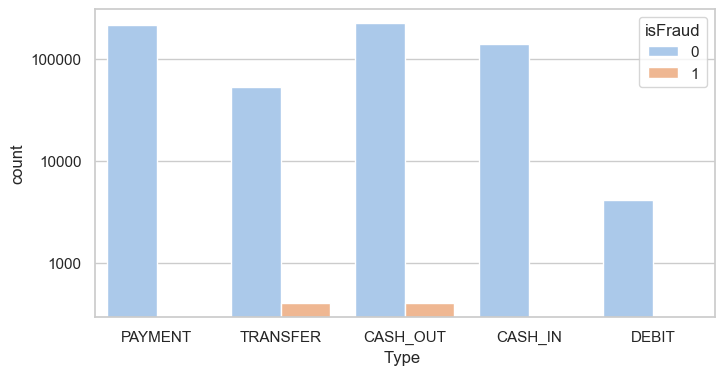

In [13]:
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.figure(figsize=(8, 4))
counplot = sns.countplot(data=sample_df, x='type', hue='isFraud', palette="pastel")
counplot.set_xlabel('Type ')
counplot.set_ylabel(f'count')
counplot.set_yscale('log')
counplot.yaxis.set_major_formatter(mticker.ScalarFormatter())
plt.show()

<Axes: ylabel='count'>

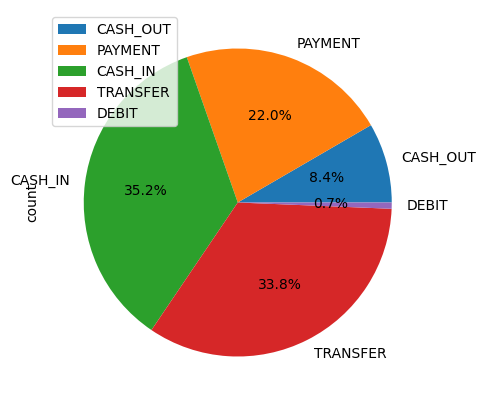

In [ ]:
# create a pie chart to visualize all 'type' of transactions and among them which are Fraudulent transactions
result_df.groupBy('type').count().toPandas().plot(kind='pie', y='count', labels=['CASH_OUT', 'PAYMENT', 'CASH_IN', 'TRANSFER', 'DEBIT'], autopct='%1.1f%%', figsize=(5, 5))

<Axes: title={'center': 'Fraudulent Transactions'}, ylabel='count'>

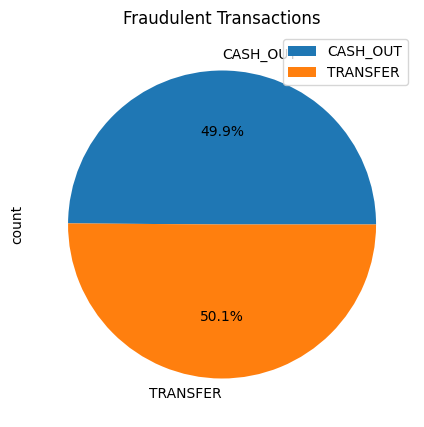

In [ ]:
# mention the percentage of Fraudulent transactions in the pie chart with title as 'Fraudulent Transactions' 
result_df.filter(result_df['isFraud'] == 1).groupBy('type').count().toPandas().plot(kind='pie', y='count', labels=['CASH_OUT', 'TRANSFER'], autopct='%1.1f%%', figsize=(5, 5), title='Fraudulent Transactions')

##### It is important to understand the distribution of our data, since it can play a major role in model building and also in understanding our data. Going forward we will be using only 10% rows as it takes a lot of time to process all the records for viz and model building. Here we check for the distribution of amount transacted using the application

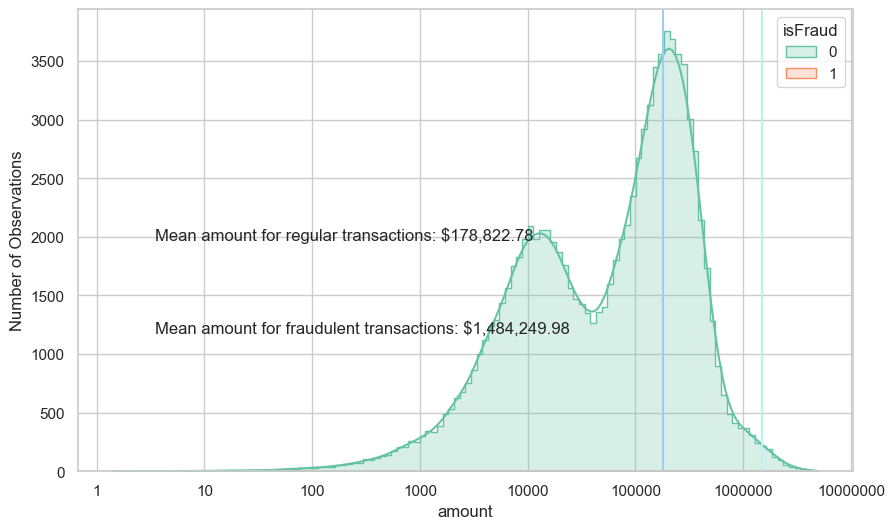

In [14]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("pastel")
histplot = sns.histplot(data=sample_df[:100000], x='amount', hue='isFraud', kde=True, element='step', palette="Set2", log_scale=True)
histplot.set_ylabel('Number of Observations')
histplot.set_xlabel(f'amount')
mean_value_f = sample_df[sample_df['isFraud'] == False]['amount'].mean()
mean_value_t = sample_df[sample_df['isFraud'] == True]['amount'].mean()
histplot.axvline(x=mean_value_f, color=palette[0])
histplot.axvline(x=mean_value_t, color=palette[-1])
histplot.annotate(f'Mean amount for regular transactions: ${mean_value_f:,.2f}', xy=(0.1, 0.5), xycoords='axes fraction')
histplot.annotate(f'Mean amount for fraudulent transactions: ${mean_value_t:,.2f}', xy=(0.1, 0.3), xycoords='axes fraction')
histplot.xaxis.set_major_formatter(mticker.ScalarFormatter())
histplot.ticklabel_format(style='plain', axis='x')
plt.show()

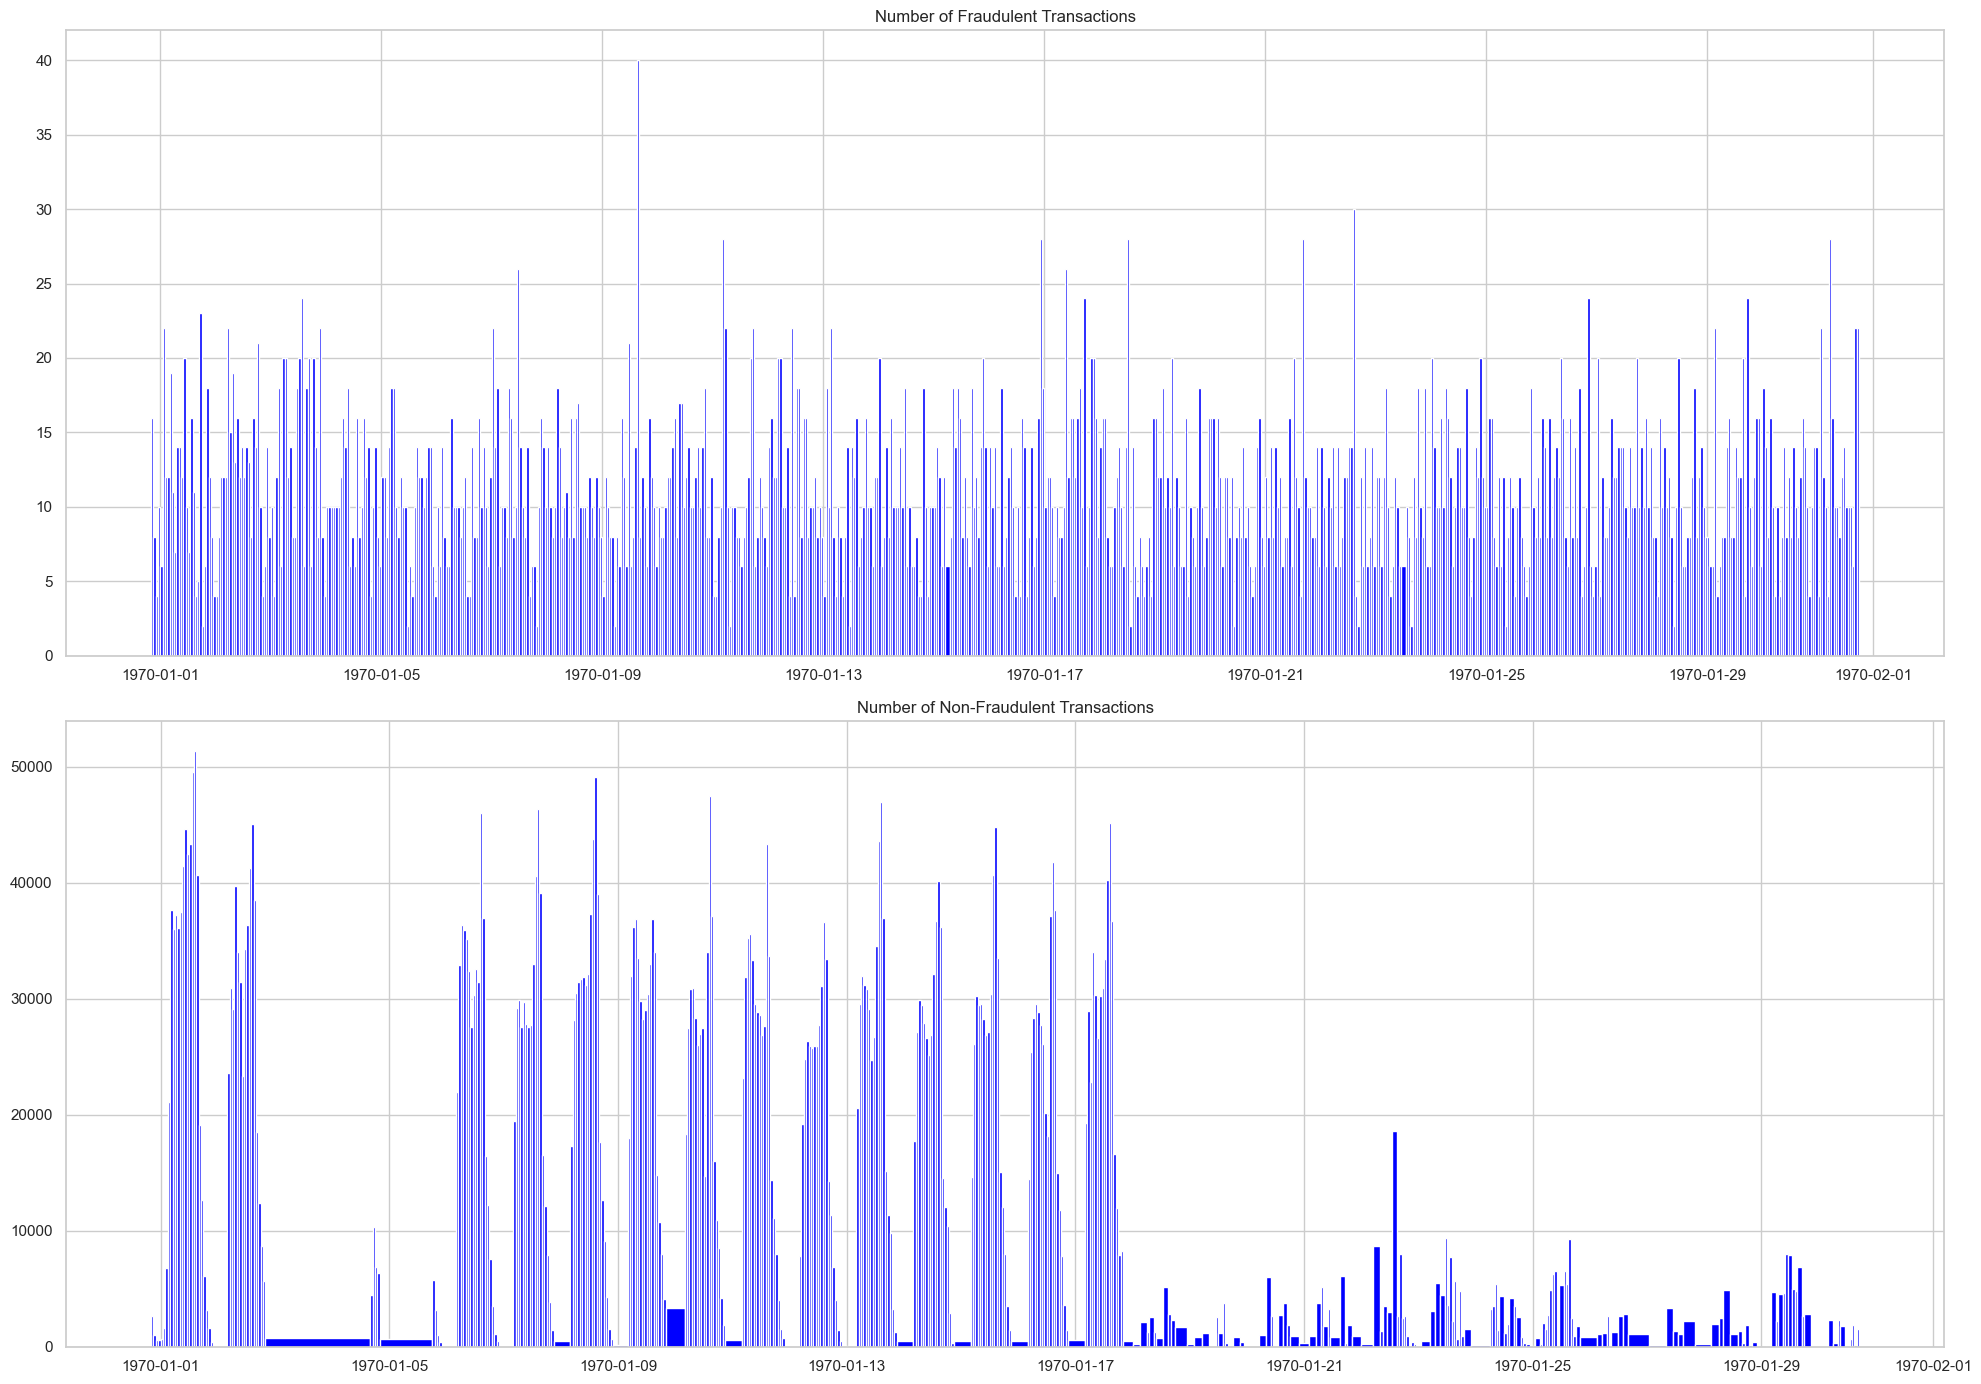

In [15]:
#result_pandas_df = result_df.toPandas()

fig = plt.figure()
fig.set_size_inches(20, 14)

ax_1 = fig.add_subplot(2, 1, 1)
fraudulent_bins = sorted(result_df[result_df['isFraud'] == 1].select('res_data').distinct().rdd.flatMap(lambda x: x).collect())
plt.hist(result_df[result_df['isFraud'] == 1].select('res_data').rdd.flatMap(lambda x: x).collect(), bins=fraudulent_bins, color="blue")
ax_1.set(title='Number of Fraudulent Transactions')

ax_2 = fig.add_subplot(2, 1, 2)
non_fraudulent_bins = sorted(result_df[result_df['isFraud'] == 0].select('res_data').distinct().rdd.flatMap(lambda x: x).collect())
plt.hist(result_df[result_df['isFraud'] == 0].select('res_data').rdd.flatMap(lambda x: x).collect(), bins=non_fraudulent_bins, color="blue")
ax_2.set(title='Number of Non-Fraudulent Transactions')

fig.tight_layout()
plt.show()


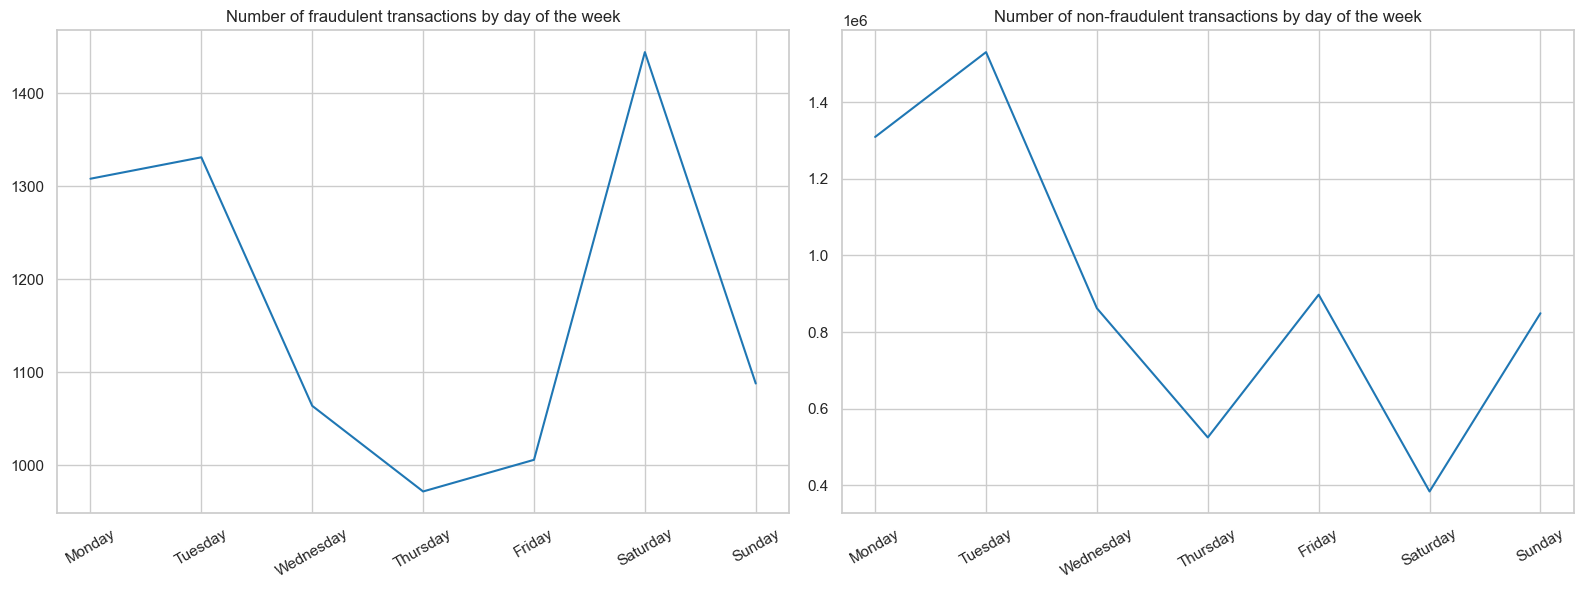

In [16]:
fig = plt.figure()
fig.set_size_inches(16, 6)
ax_1 = fig.add_subplot(1, 2, 1)
plt.plot(result_df[result_df['isFraud'] == 1].groupby(['day_of_week']).count().toPandas()['count'])
plt.xticks(range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=30)

ax_2 = fig.add_subplot(1, 2, 2)
plt.plot(result_df[result_df['isFraud'] == 0].groupby(['day_of_week']).count().toPandas()['count'])
plt.xticks(range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=30)

fig.tight_layout()
ax_1.set(title='Number of fraudulent transactions by day of the week')
ax_2.set(title='Number of non-fraudulent transactions by day of the week')
plt.show()

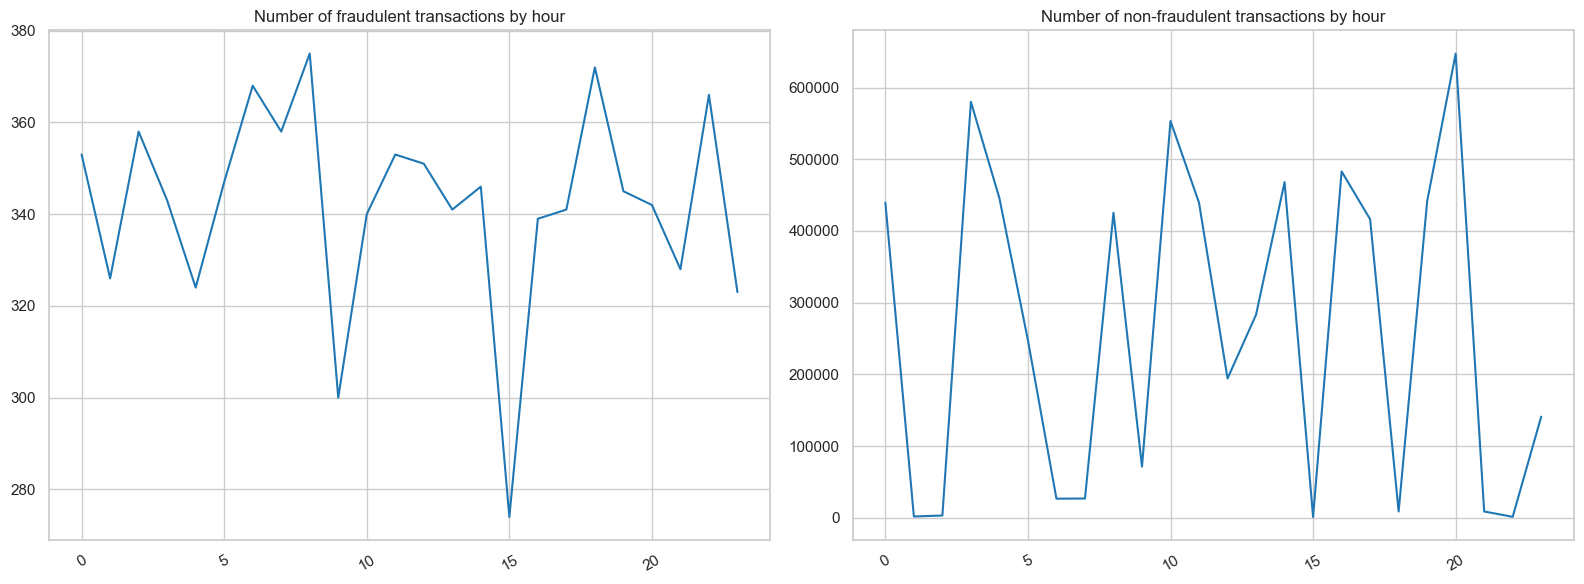

In [17]:
fig = plt.figure()
fig.set_size_inches(16, 6)

ax_1 = fig.add_subplot(1, 2, 1)
plt.plot(result_df[result_df['isFraud'] == 1].groupby(['hour']).count().toPandas()['count'])
plt.xticks(rotation=30)
ax_1.set(title='Number of fraudulent transactions by hour')

ax_2 = fig.add_subplot(1, 2, 2)
plt.plot(result_df[result_df['isFraud'] == 0].groupby(['hour']).count().toPandas()['count'])
plt.xticks(rotation=30)
ax_2.set(title='Number of non-fraudulent transactions by hour')

fig.tight_layout()
plt.show()


### Average target curves by hours for each day of the week

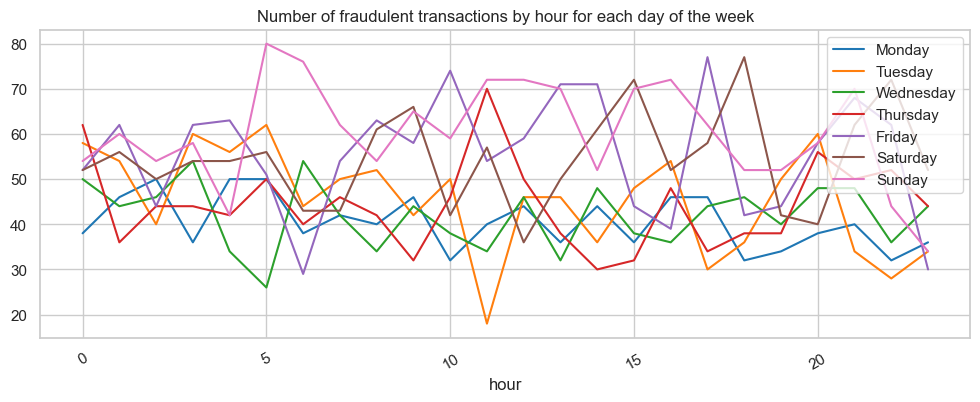

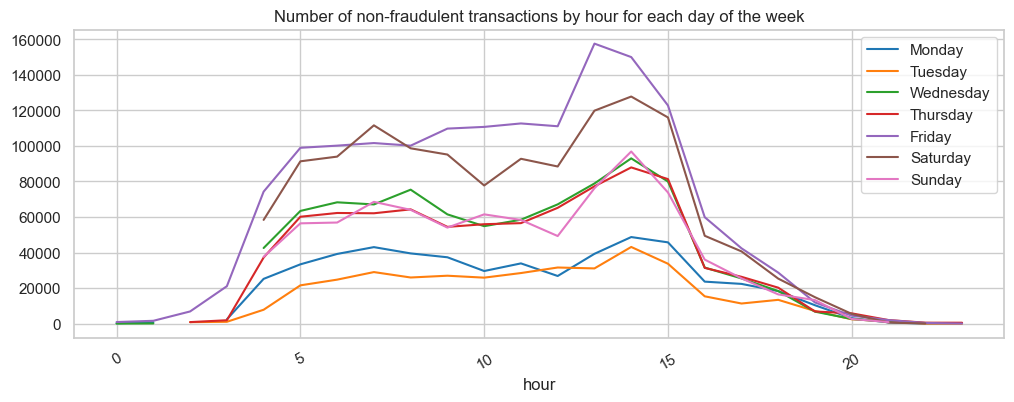

In [20]:
# Average target curves by hours for each day of the week
# Average target curves by hours for each day of the week
frame1 = (
    result_df
    .filter(result_df['isFraud'] == 1)
    .groupBy(['day_of_week', 'hour'])
    .agg(F.count('amount').alias('count'))
    .orderBy(['hour', 'day_of_week'])
    .toPandas()
    .pivot(index='hour', columns='day_of_week', values='count')
)

frame1.plot(figsize=(12, 4), color=['#1f77b4', '#ff7f0e', '#2ca02c',
                                    '#d62728', '#9467bd', '#8c564b', '#e377c2'])
plt.xticks(rotation=30)
plt.title('Number of fraudulent transactions by hour for each day of the week')
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


frame2 = (
    result_df
    .filter(result_df['isFraud'] == 0)
    .groupBy(['day_of_week', 'hour'])
    .agg(F.count('amount').alias('count'))
    .orderBy(['hour', 'day_of_week'])
    .toPandas()
    .pivot(index='hour', columns='day_of_week', values='count')
)

frame2.plot(figsize=(12, 4), color=['#1f77b4', '#ff7f0e', '#2ca02c',
                                    '#d62728', '#9467bd', '#8c564b', '#e377c2'])
plt.xticks(rotation=30)
plt.title('Number of non-fraudulent transactions by hour for each day of the week')
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

## Balancing the target label by taking the same number of Fraud and Non-Fraud transactions

In [21]:
fraud_count = df.filter(col('isFraud') == 1).count()
non_fraud_count = df.filter(col('isFraud') == 0).count()
imbalance_ratio = fraud_count / non_fraud_count
class_weights = {0: 1.0, 1: imbalance_ratio}

print("Fraud Count: ", fraud_count)
print("Non-Fraud Count: ", non_fraud_count)
print("Imbalance Ratio: ", imbalance_ratio)
print("Class Weights: ", class_weights)

Fraud Count:  8213
Non-Fraud Count:  6354407
Imbalance Ratio:  0.0012924888191769902
Class Weights:  {0: 1.0, 1: 0.0012924888191769902}


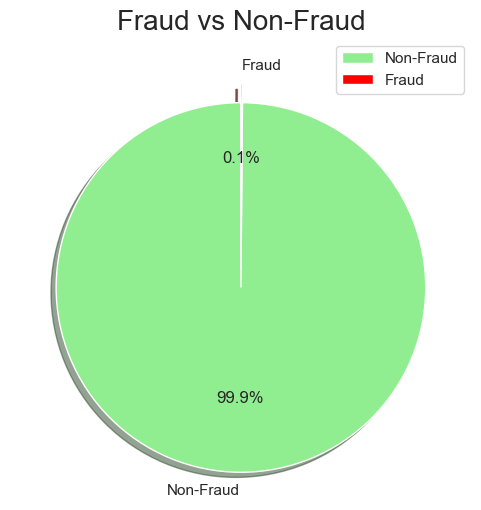

In [ ]:
# Pie-chart for Fraud vs Non-Fraud
labels = ['Non-Fraud', 'Fraud']
colors = ['lightgreen', 'red']
explode = (0.1, 0)  # explode 1st slice
plt.rcParams['figure.figsize'] = (6, 6)
plt.pie(sample_df['isFraud'].value_counts(), explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Fraud vs Non-Fraud', fontsize=20)
plt.axis('off')
plt.legend()
plt.show()

#### From the pie chart below we can clearly see that the target label is heavily imbalance as we have only 0.1% of fraudulent data which is in-sufficient for machine to learn and flag when fraud transactions happen.

In [22]:
fraud_df = df.filter(col('isFraud') == 1)
non_fraud_df = df.filter(col('isFraud') == 0).sample(fraction=1.0, seed=42).limit(fraud_count)
balanced_df = fraud_df.union(non_fraud_df)
print("Balanced Dataframe Count: ", balanced_df.count())

Balanced Dataframe Count:  16426


In [23]:
balanced_df.columns

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud',
 'total_balance',
 'error_balance']

In [24]:
feature_cols = ['type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'total_balance', 'error_balance']

In [25]:
# df.head()

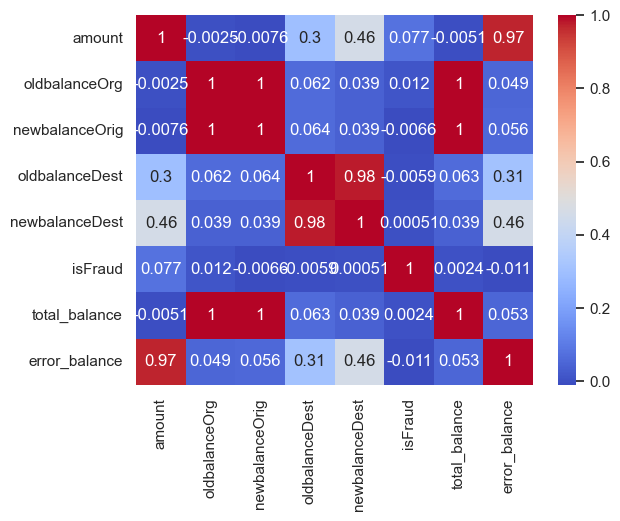

In [26]:
cols = [col for col in sample_df.columns if sample_df[col].dtype in [np.int64, np.int32, np.float64]]
sample_df_heatmap = sample_df[cols]
sns.heatmap(sample_df_heatmap.corr(), annot=True, cmap='coolwarm')
plt.show()


In [27]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

assembler

VectorAssembler_861e61a00e61

# Random Forest Classifier 

In [28]:
(training_data, test_data) = balanced_df.randomSplit([0.8, 0.2], seed=42)

In [29]:
rf = RandomForestClassifier(labelCol='isFraud', featuresCol='features')
pipeline = Pipeline(stages=indexers + [encoder, assembler, rf])
model = pipeline.fit(training_data)

In [30]:
predictions = model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol='isFraud', metricName='areaUnderROC')
area_under_roc = evaluator.evaluate(predictions)
print(f"Area under ROC on the test set: {area_under_roc}") #Random Forest

Area under ROC on the test set: 0.9999248794046155


In [31]:
# model.save("fraud_detection_model.pkl")

In [32]:
param_grid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 30]).build()
evaluator = BinaryClassificationEvaluator(labelCol='isFraud', metricName='areaUnderROC')
cross_validator = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

In [33]:
model = cross_validator.fit(training_data)

In [34]:
predictions = model.transform(test_data)
area_under_roc = evaluator.evaluate(predictions)
print(f"Area under ROC on the test set: {area_under_roc}")

Area under ROC on the test set: 0.9998183308050398


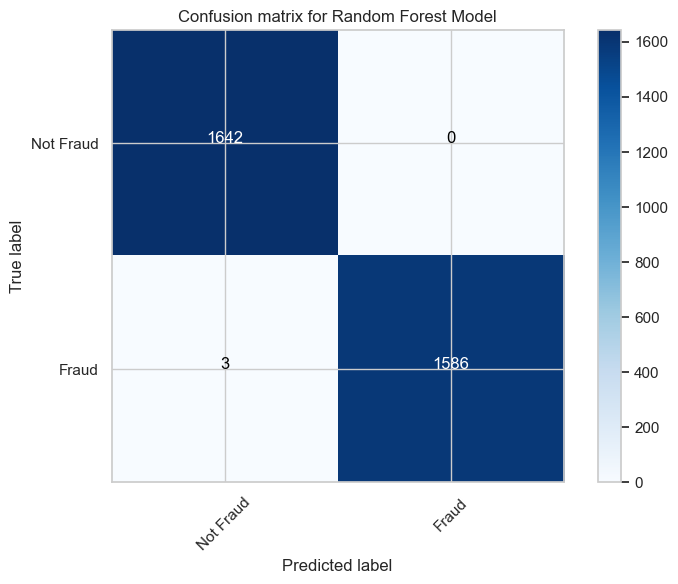

In [36]:
#Plotting confusion matrix for the Random Forest model
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

y_true = predictions.select("isFraud")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

class_names = ['Not Fraud', 'Fraud']

#Plotting confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix for Random Forest Model')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]),
    horizontalalignment="center",
    color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [37]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00      1642
       Fraud       1.00      1.00      1.00      1589

    accuracy                           1.00      3231
   macro avg       1.00      1.00      1.00      3231
weighted avg       1.00      1.00      1.00      3231



# Decision Tree Classifier 

In [38]:
# Decision Tree Classifier 
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol='isFraud', featuresCol='features')
pipeline = Pipeline(stages=indexers + [encoder, assembler, dt])

model = pipeline.fit(training_data)

In [39]:
predictions = model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol='isFraud', metricName='areaUnderROC')
area_under_roc = evaluator.evaluate(predictions)
print(f"Area under ROC on the test set: {area_under_roc}") #Decision Tree

Area under ROC on the test set: 0.9986179343522651


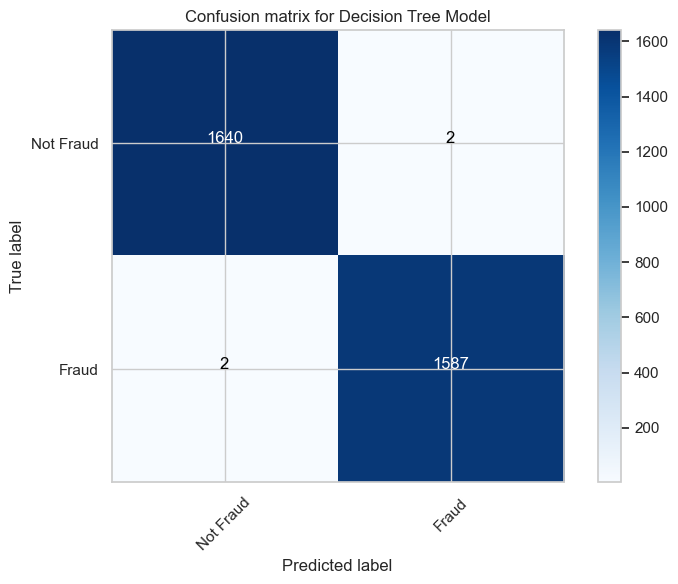

In [40]:
y_true = predictions.select("isFraud")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

class_names = ['Not Fraud', 'Fraud']

#Plotting confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix for Decision Tree Model')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]),
    horizontalalignment="center",
    color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [41]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00      1642
       Fraud       1.00      1.00      1.00      1589

    accuracy                           1.00      3231
   macro avg       1.00      1.00      1.00      3231
weighted avg       1.00      1.00      1.00      3231



# Gradient Boosting Classifier

In [42]:
# Gradient Boosting Classifier
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol='isFraud', featuresCol='features')
pipeline = Pipeline(stages=indexers + [encoder, assembler, gbt])

model = pipeline.fit(training_data)

In [43]:
predictions = model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol='isFraud', metricName='areaUnderROC')
area_under_roc = evaluator.evaluate(predictions)
print(f"Area under ROC on the test set: {area_under_roc}") # Gradient Boosting Classifier

23/11/29 11:47:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Area under ROC on the test set: 0.9997886275083954


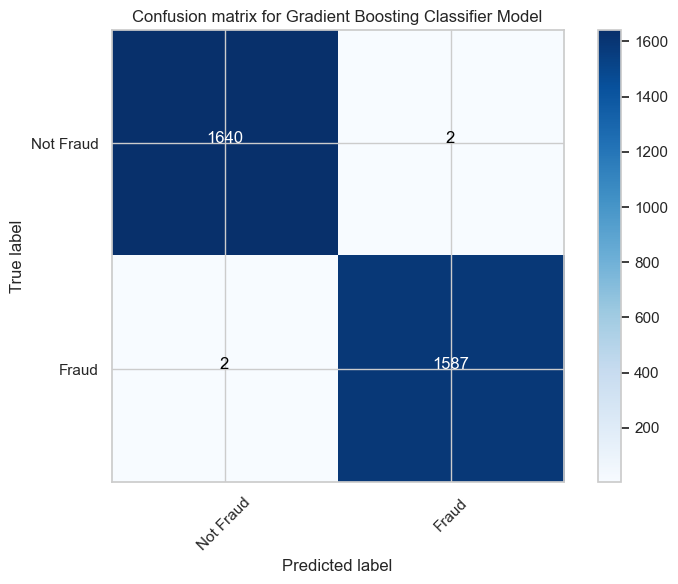

In [44]:
y_true = predictions.select("isFraud")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

class_names = ['Not Fraud', 'Fraud']

#Plotting confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix for Gradient Boosting Classifier Model')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]),
    horizontalalignment="center",
    color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [45]:
# print classification report 
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00      1642
       Fraud       1.00      1.00      1.00      1589

    accuracy                           1.00      3231
   macro avg       1.00      1.00      1.00      3231
weighted avg       1.00      1.00      1.00      3231

